In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
np_data = np.loadtxt("./data/Kissler_DataS1.csv", delimiter=",")
df_data = pd.DataFrame(np_data)
df_data.columns = ['Time', 'Person1', 'Person2', 'Distance']

In [3]:
from enum import Enum

#1, 193, 385 = beginnings of days

# S = susceptible, E = exposed, I = infected, R = recovered
class State():
    S, E, I, R = range(4)
    
# Duration in timesteps before moving on to next state. (1 timestep = 5 minutes)
class Duration():
    E, I = 5, 572

class SEIR_Simulator:
    # Source: https://github.com/skissler/haslemere/blob/master/Kissler_SI.pdf
    
    def __init__(self, df):
        """
        Parameters and their values
        
        xi       Infection cutoff distance. d > xi -> no chance of infection.
        a        Value of F at d = 0
        rho      Value of F at d = 1/e
        
        n        Number of people
        maxtime  Maximum number of timesteps provided in simulation data
        """
        self.df = df.copy()
        self.df['Time'] = self.df['Time'] - 1
        self.df['Person1'] -= 1
        self.df['Person2'] -= 1
        
        # Force of infection parameters. F(d) = 0 if d > xi, and a * exp(d/rho) otherwise.
        
        self.xi = 20.0 
        # 
        self.a = 1.0
        # 
        self.rho = 10.0 
        
        self.n = int(df_data['Person2'].max())
        self.state = np.array([State.S] * self.n)
        self.timer = np.array([0] * self.n) # Countdown to move to next state.
        self.susceptible = np.array([True] * self.n)
        self.infectious = np.array([False] * self.n)
        
        # Create tdmatrix. tdmatrix[t,i,j] = distance between i and j at timestep t.
        self.maxtime = int(df_data['Time'].max())
        self.tdmatrix = np.zeros((self.maxtime, self.n, self.n))
        self.tdmatrix.fill(self.xi+1) # if no edge exists, set d > xi to simulate no contact.
        times = self.df['Time'].to_numpy().astype(int)
        p1s = self.df['Person1'].to_numpy().astype(int)
        p2s = self.df['Person2'].to_numpy().astype(int)
        distances = self.df['Distance'].to_numpy()
        coords = np.vstack([times, p1s, p2s]).T
        for i in range(coords.shape[0]):
            coord = coords[i]
            self.tdmatrix[coord[0], coord[1], coord[2]] = distances[i]
        
    def set_state(self, indices, s):
        if s == State.S:
            self.state[indices] = State.S
            self.susceptible[indices] = 1
            self.infectious[indices] = 0
        elif s == State.E:
            self.state[indices] = State.E
            self.timer[indices] = Duration.E
            self.susceptible[indices] = 0
            self.infectious[indices] = 0
        elif s == State.I:
            self.state[indices] = State.I
            self.timer[indices] = Duration.I
            self.susceptible[indices] = 0
            self.infectious[indices] = 1
        elif s == State.R:
            self.state[indices] = State.R
            self.susceptible[indices] = 0
            self.infectious[indices] = 0
            
    def infect_k_random(self, k):
        # Randomly infect k individuals.
        # This function assumes all individuals are currently not infected.
        indices = np.random.choice(np.arange(self.n), replace=False, size=k)
        self.set_state(indices, State.I)

    def probability_of_exposure_vectorized(self, t):
        currdists = self.tdmatrix[t]
        forcematrix = (currdists <= self.xi) * self.a * np.exp(-currdists / self.rho) * self.infectious
#         print(np.nonzero(forcematrix))
#         print(np.nonzero(self.infectious))
        probs = forcematrix.dot(np.ones(self.n)) * self.susceptible
        return probs
    
    def probability_of_exposure(self, i, t):
        if self.susceptible[i] == 0:
            return 0
        def force_of_infection(i, t):
            # Force of infection on individual i at timestep t.
            df = self.df
            df = df[df['Time'] == t] # Timestep t
            df_1 = df[(df['Person1'] == i)]
            df_2 = df[(df['Person2'] == i)]
            # Person i must be susceptible and the other person must be infectious
            infectious_1 = self.infectious[df_1['Person2'].to_numpy().astype(int)]
            df_1 = df_1['Distance'].to_numpy()
            df_1 = df_1[infectious_1]
            df_1 = df_1[df_1 <= self.xi]
            
            infectious_2 = self.infectious[df_2['Person1'].to_numpy().astype(int)]
            df_2 = df_2['Distance'].to_numpy() 
            df_2 = df_2[infectious_2]
            df_2 = df_2[df_2 <= self.xi]
            force = np.sum(self.a * np.exp(-np.concatenate([df_1, df_2]) / self.rho))
            return force
        return 1 - np.exp(-force_of_infection(i, t))
        
    def printSEIR(self, t):
            num_S = np.sum(self.state == State.S)
            num_E = np.sum(self.state == State.E)
            num_I = np.sum(self.state == State.I)
            num_R = np.sum(self.state == State.R)
            print(f"{t:4}: {num_S:4} {num_E:4} {num_I:4} {num_R:4}")
            
    def simulate(self, timesteps=576, logsteps=False):
        
        if logsteps == True:
            print(f"{'t':>4}: {'S':>4} {'E':>4} {'I':>4} {'R':>4}")
            print("===========================")
            self.printSEIR("init")
            
        # Initialize SEIR history
        S, E, I, R = [], [], [], []
        
        for t in range(0, timesteps):
            
            tind = t % self.maxtime
            
            # S -> E
            exposed_probabilities = self.probability_of_exposure_vectorized(tind)
            p = np.random.random(self.n)
            transition_indices = p < exposed_probabilities
            self.set_state(transition_indices, State.E)
            
            # E -> I
            transition_indices = self.state == State.E
            transition_indices &= self.timer == 0
            self.set_state(transition_indices, State.I)
            
            # I -> R
            transition_indices = self.state == State.I
            transition_indices &= self.timer == 0
            self.set_state(transition_indices, State.R)
            
            # decrease timers
            self.timer = np.maximum(0, self.timer-1)
            
            if logsteps == True:
                self.printSEIR(t+1)
                
            S.append(np.sum(self.state == State.S))
            E.append(np.sum(self.state == State.E))
            I.append(np.sum(self.state == State.I))
            R.append(np.sum(self.state == State.R))
            
        return S, E, I, R

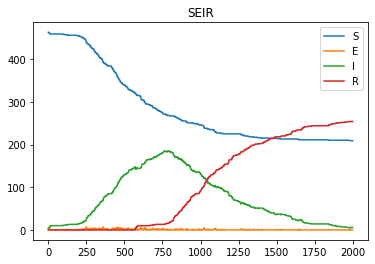

In [4]:
def plot_SEIR(S, E, I, R):
    steps = range(len(S))
    plt.figure()
    plt.title("SEIR")
    plt.plot(steps, S, label="S")
    plt.plot(steps, E, label="E")
    plt.plot(steps, I, label="I")
    plt.plot(steps, R, label="R")
    plt.legend()
    plt.show()
    
sim = SEIR_Simulator(df_data)
sim.infect_k_random(5)
results = sim.simulate(timesteps=2000, logsteps=False)
plot_SEIR(*results)
